In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and Pytorch Settings

In [62]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

sys.path.append(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\src")
from model import BuildNetwork, BuildNetwork_previous
from train import run_model
from transfer_learning import compute_H_and_dH_dt, analytically_compute_weights
from utils_plot import plot_loss_mse_and_all_solution, plot_transfer_learned_and_analytical, plot_head_loss
from load_save import save_model, load_run_history

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

# Check Library Version Info and GPU Availability

In [63]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Thu Jan  4 11:39:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              N/A / ERR! |   1726MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Set-up Differential Equations

In [ ]:
num_heads = 4
x_range = [0, 10]
# for damped harmonic oscillator: DHO

# stiff parameter alpha list
alpha_list =[1, 3, 4, 6]

# A matrix (A = -Jacobian because system: up + Au = f)
A_DHO = [torch.tensor([[0., -1.], [1., 2*i]], device=dev) for i in alpha_list]

force_DHO = [torch.tensor([[0.], [0.]], device=dev) for _ in range(num_heads)]

IC_list_DHO = [torch.tensor([[1.], [0.5]], device=dev) for _ in range(num_heads)]

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

true_coupled_2_eq = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)
true_func_dict = {}
true_func_dict["true_coupled_2_eq"] = true_coupled_2_eq

# Choose Network Parameters and

In [47]:
# set-up network training parameters
x_range = [0, 10]
hid_lay = list(np.array([128, 128, 132]) * 1)
num_equations = 2
num_heads = 4
iterations = 10

#### Damped Harmonic Hoscillator (DHO)
![Alt text](https://github.com/eseiler18/Harvard_Master_Thesis/blob/main/src/image-1.png?raw=1)

In [41]:
# set-up linear ODE and initial condition
# for damped harmonic oscillator: DHO

# stiff parameter alpha list
# alpha_list =[1, 3, 4, 6]
alpha_list =[5, 10, 20, 25]

# A matrix (A = -Jacobian because system: up + Au = f)
A_DHO = [torch.tensor([[0., -1.], [1., 2*i]], device=dev) for i in alpha_list]

force_DHO = [torch.tensor([[0.], [0.]], device=dev) for _ in range(num_heads)]

IC_list_DHO = [torch.tensor([[1.], [0.5]], device=dev) for _ in range(num_heads)]

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

true_coupled_2_eq = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)
true_func_dict = {}
true_func_dict["true_coupled_2_eq"] = true_coupled_2_eq

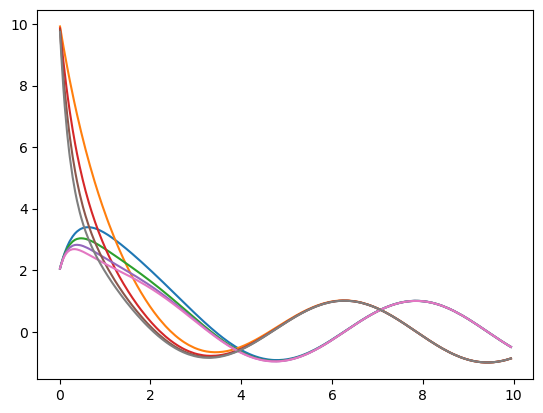

In [42]:
# set-up linear ODE and initial condition
# for exemple 1 linear stiff ode

# stiff parameter alpha list
alpha_list =[1, 2, 3, 4]

# A matrix (A = -Jacobian because system: up + Au = f)
A_list_1 = [torch.tensor([[2., -1.], [1-i, i]], device=dev) for i in alpha_list]

force_list_1 = [lambda t, i=i: [2*np.sin(t), i*(np.cos(t)-np.sin(t))] for i in alpha_list]

IC_list_1 = [torch.tensor([[2.], [10.]], device=dev) for _ in range(num_heads)]

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation_force_vary(t, y, A, force):
    return np.array([force(t)[0] - A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[1] - A[1][0] * y[0] - A[1][1] * y[1]])

true_coupled_2_force_vary_eq = lambda x, v, A, force: (solve_ivp(double_coupled_equation_force_vary, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method='Radau').y)

true_func_dict["true_coupled_2_force_vary_eq"] = true_coupled_2_force_vary_eq

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True)
t_eval = t_eval[rng.choice(range(0, len(t_eval)), size=512, replace=False)]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)
for j in range(4):
    y = true_coupled_2_force_vary_eq(t_eval.detach().cpu().numpy(),
                                    IC_list_1[j].detach().cpu().numpy(),
                                    A_list_1[j].detach().cpu().numpy(),
                                    force_list_1[j])

    plt.plot(t_eval.detach().cpu(), y[0,:])
    plt.plot(t_eval.detach().cpu(), y[1,:])

### Step 2: Run Model

In [43]:
# choose the equation(s) to work with

# DHO
equation_name = "DHO"
A_list = A_DHO
IC_list = IC_list_DHO
force = force_DHO
true_funct = true_coupled_2_eq
true_funct_str = "true_coupled_2_eq"
head_to_track = 'head 1'
is_A_time_dep = False
is_force_time_dep = False
sample_factor = 1

activation = "tanh"
hid_lay = list(np.array([128, 128, 256, 256, 132]) * 8)

# Other system
# equation_name = "Ex1"
# A_list = A_list_1
# IC_list = IC_list_1
# force = force_list_1
# true_funct = true_coupled_2_force_vary_eq
# true_funct_str = "true_coupled_2_force_vary_eq"
# head_to_track = 'head 1'
# is_A_time_dep = False
# is_force_time_dep = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=x_range,
                                                           A_list=A_list, IC_list=IC_list, force=force,
                                                           hid_lay=hid_lay, activation=activation,
                                                           num_equations=num_equations, num_heads=num_heads,
                                                           true_functs=true_funct, head_to_track=head_to_track,
                                                           sample_factor = sample_factor, is_A_time_dep=is_A_time_dep,
                                                           is_force_time_dep=is_force_time_dep, dev=dev)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

 80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Training stop after 8 because of diverge loss


In [ ]:
save_model(trained_model, formatted_datetime_int, equation_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force, true_funct_str, alpha_list, is_A_time_dep, loss_hist, MSE_hist)

### Save the model

### Step 3: View Training Results and History

In [48]:
trained_model, x_range, iterations, hid_lay, num_equations, num_heads, loss_hist, MSE_hist, alpha_list, A_list, IC_list, force_list, true_funct = load_run_history("DHO_10102021", dev, true_func_dict)


In [49]:
#force_list = [lambda t, i=i: [2*np.sin(t), i*(np.cos(t)-np.sin(t))] for i in alpha_list]
force_list = [force_list for i in range(len(A_list))]

In [50]:
A_list
force_list

[tensor([[0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 tensor([[0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 tensor([[0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 tensor([[0.],
         [0.]], device='cuda:0', dtype=torch.float64)]

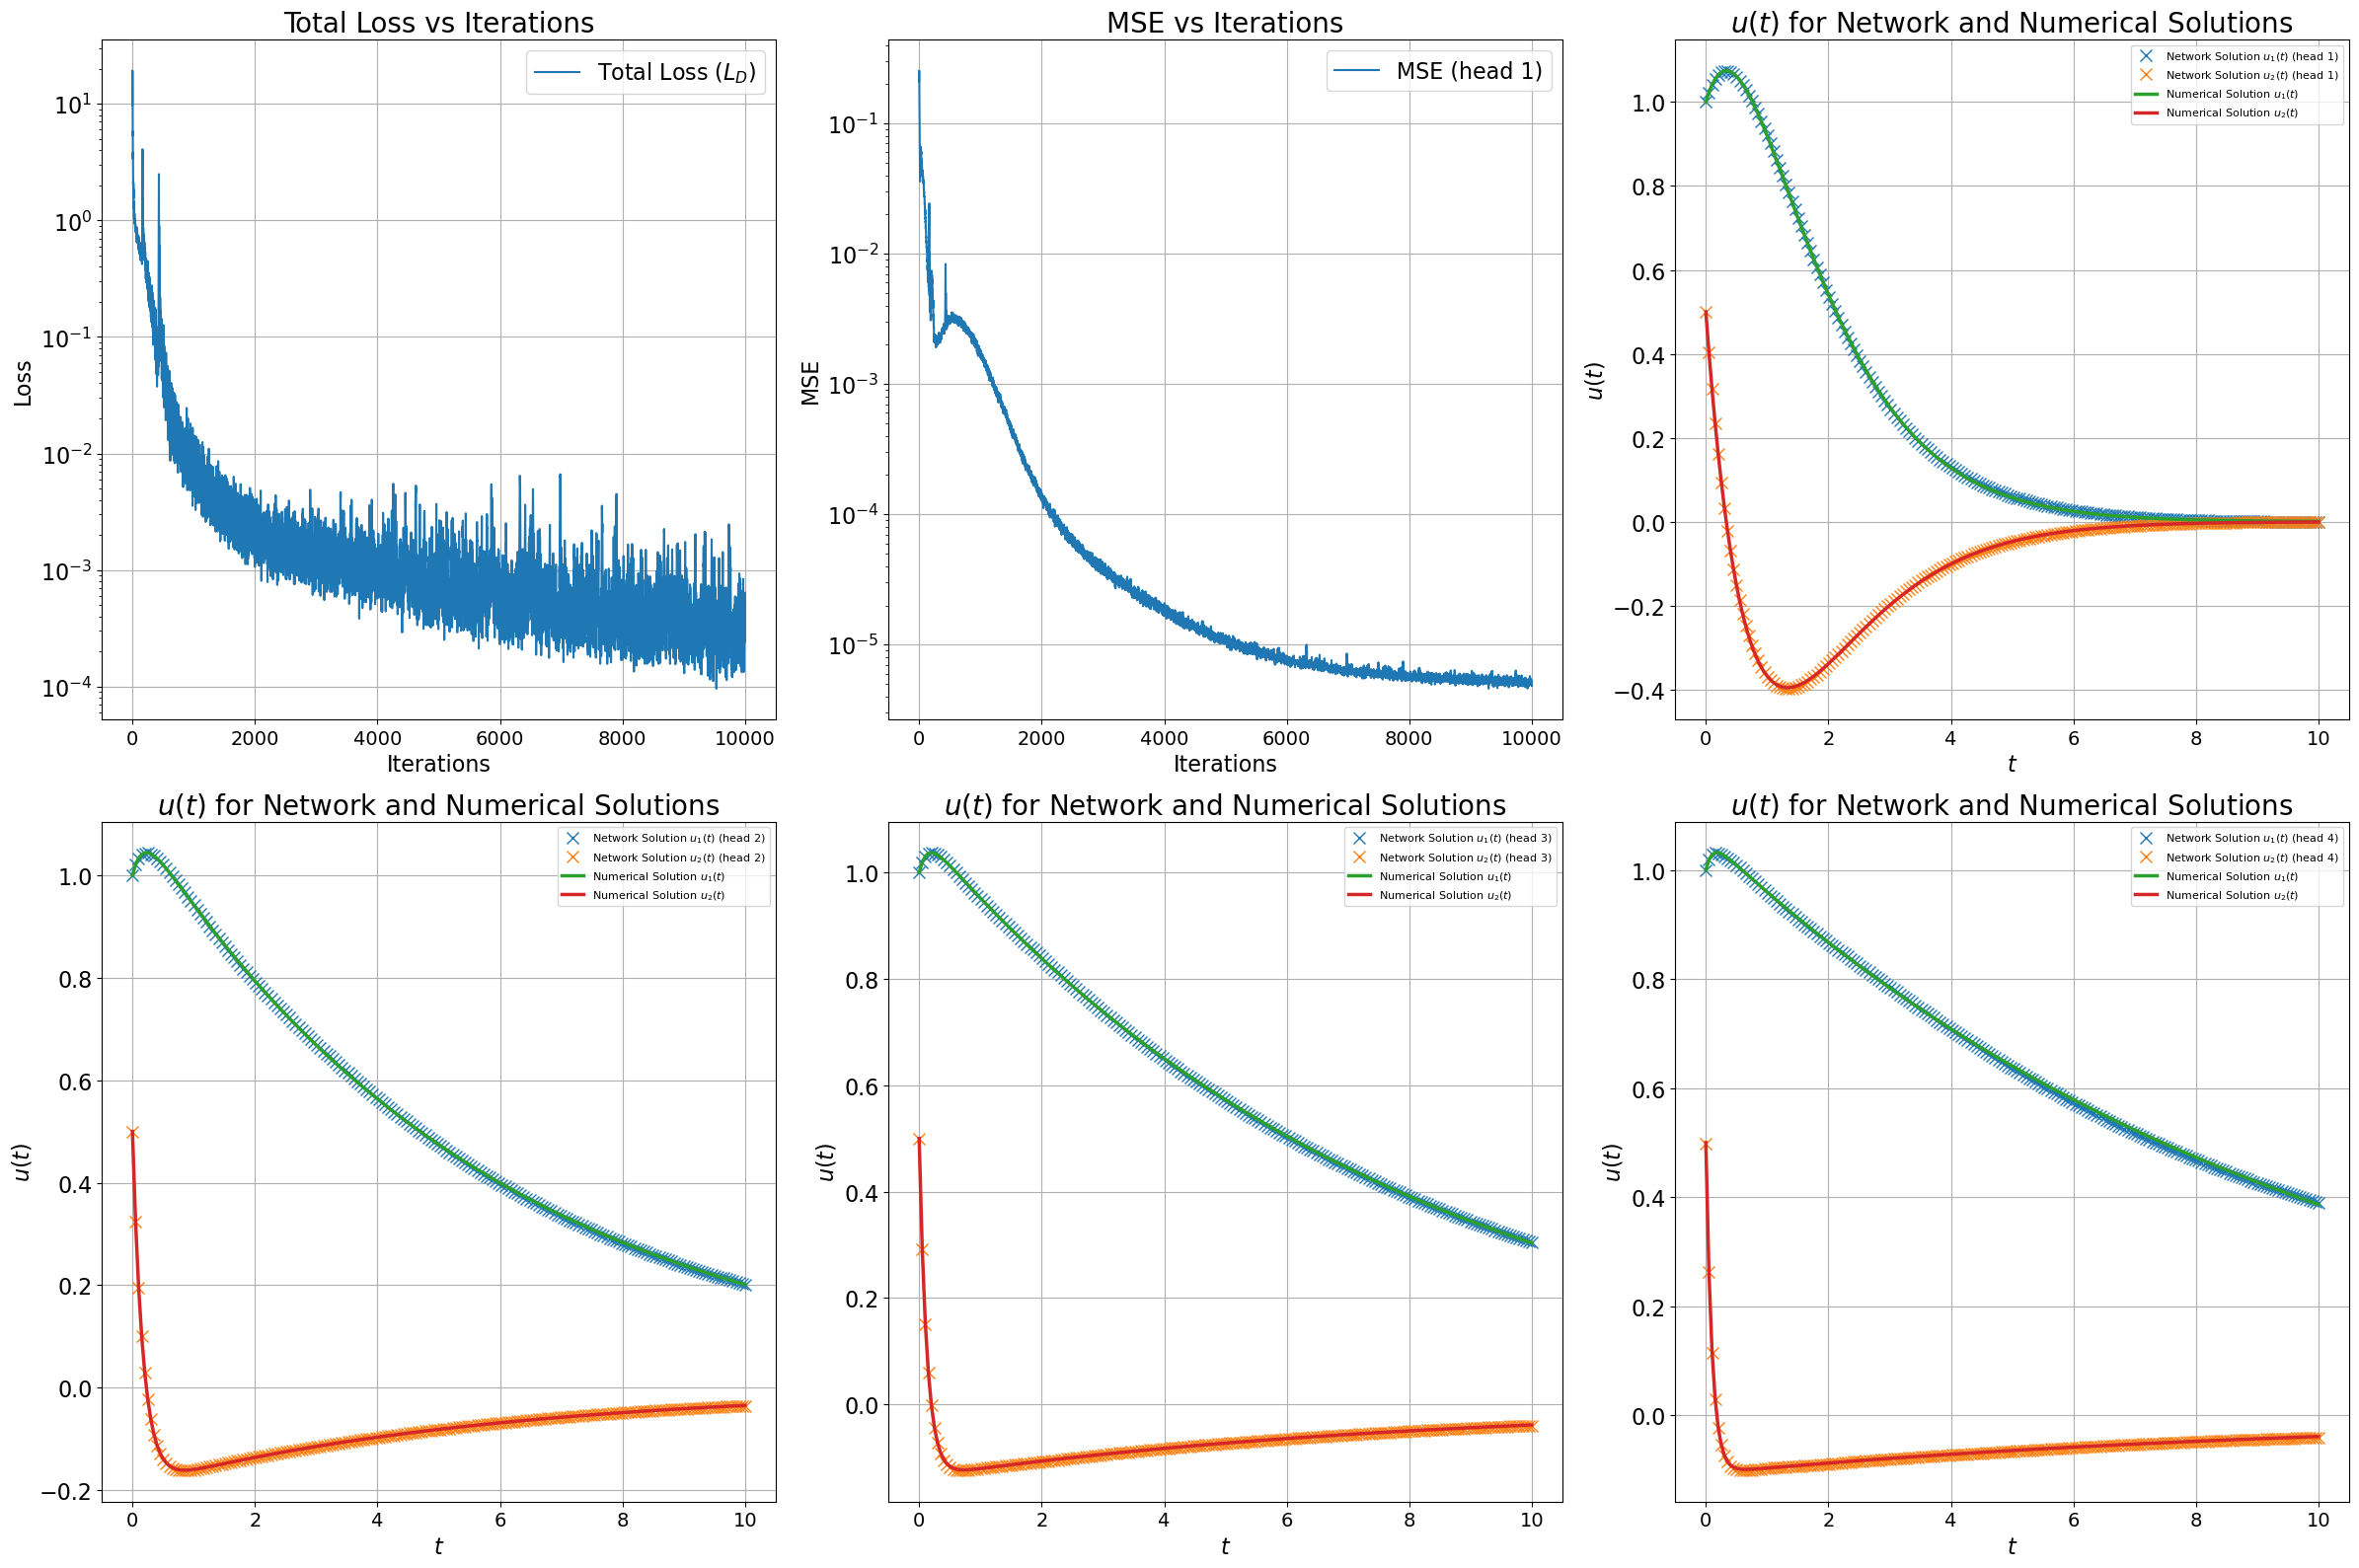

In [51]:
is_A_time_dep = False
is_force_time_dep = False
plot_loss_mse_and_all_solution(x_range=x_range, true_functs=true_funct, iterations=iterations,
                           trained_model=trained_model, IC_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['Ltotal_losses'],
                           loss_label='Total Loss ($L_D$)', mses=MSE_hist,
                           is_A_time_dep=is_A_time_dep, is_force_time_dep=is_force_time_dep, device=dev)


[1, 3, 4.0, 5.0]


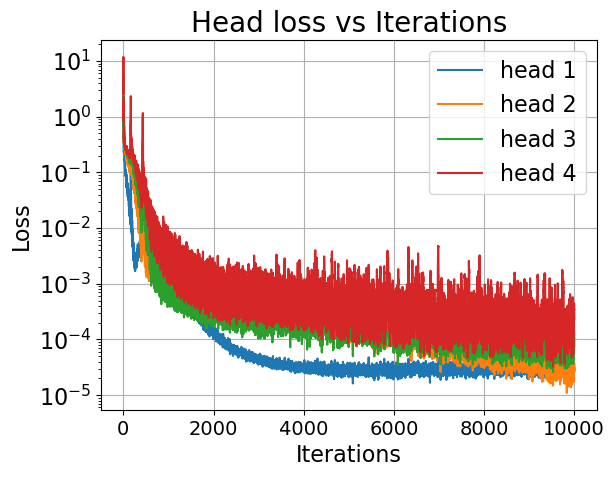

In [52]:
fig, ax = plt.subplots(1)
plot_head_loss(loss_hist["head"], ax)
print(alpha_list)

### Step 4a: Recover Weights for a Set of Training Parameters

Time to compute H and dH_dt:  0.083 seconds
Time to compute weights (given H and dH_dt):  0.183 seconds
mean 4.930461640428895e-06
max 6.236385480112849e-05
mean -1.3036557424055836e-06
max 3.0309517823512433e-05


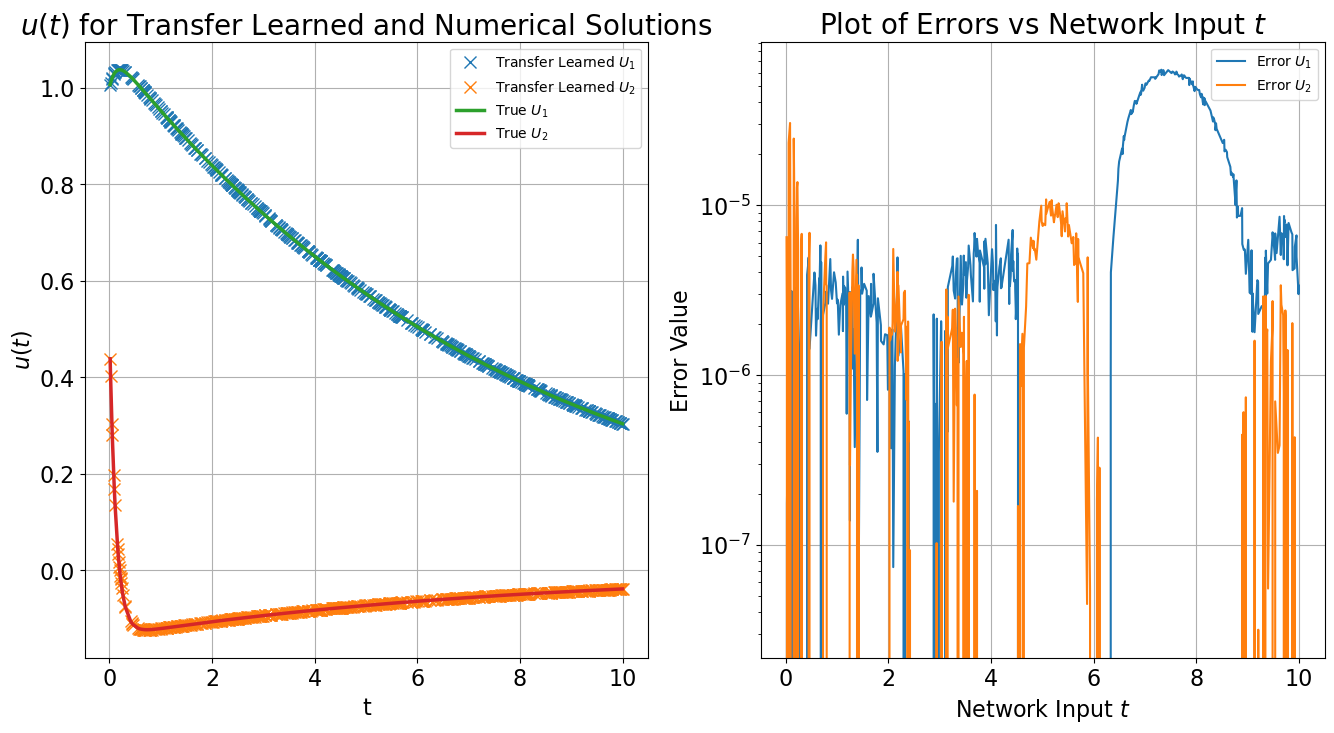

In [57]:
# forward pass to extract H
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, dev)

# choose an initial condition and set of coefficients that were trained on
v = IC_list[2]
A = A_list[2]
force = force_list[2]
M_inv, W_out, force_terms = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                         v, A, force, is_A_time_dep,
                                                         is_force_time_dep, num_equations, dev)
plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force,
                                     num_equations, true_funct, is_A_time_dep,
                                     is_force_time_dep)

### Step 4b: Perform One-Shot Transfer Learning - New Equation Coefficients

Time to compute weights (given H and dH_dt):  0.067 seconds
mean 0.0006837035928239199
max 0.0017569298739036343
mean 5.507853566822899e-05
max 0.015435709740575343


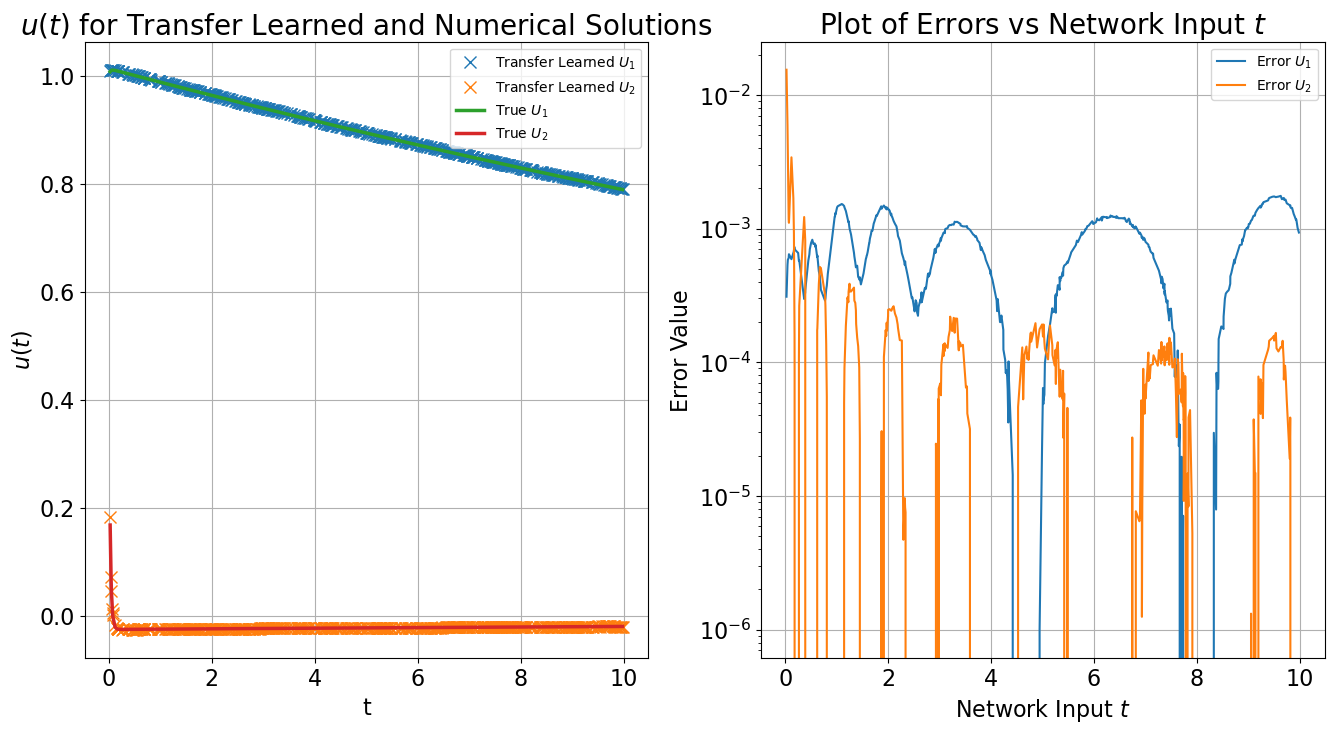

In [28]:
# stiff parameter alpha list
alpha_transfer = 20
# choose a new set of equation coefficients

# DHO
transfer_A = torch.tensor([[0., -1.], [1., 2*alpha_transfer]], device=dev)
force_transfer = force

# Exemple 1
# transfer_A = torch.tensor([[2., -1.], [1-alpha_transfer, alpha_transfer]], device=dev)
# force_transfer = lambda t: [2*np.sin(t), alpha_transfer*(np.cos(t)-np.sin(t))]


# compute the transfer learned solution
M_inv_new, W_out_new_A, force_terms_new = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                       v, transfer_A, force_transfer, is_A_time_dep,
                                                                       is_force_time_dep, num_equations)

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_new_A, t_eval, v, transfer_A, force_transfer,
                                     num_equations, true_funct, is_A_time_dep, is_force_time_dep)

Time to compute weights (given H and dH_dt):  0.174 seconds
Time to compute weights (given H and dH_dt):  0.085 seconds
Time to compute weights (given H and dH_dt):  0.074 seconds
Time to compute weights (given H and dH_dt):  0.066 seconds
Time to compute weights (given H and dH_dt):  0.068 seconds
Time to compute weights (given H and dH_dt):  0.050 seconds
Time to compute weights (given H and dH_dt):  0.072 seconds
Time to compute weights (given H and dH_dt):  0.057 seconds
Time to compute weights (given H and dH_dt):  0.055 seconds
Time to compute weights (given H and dH_dt):  0.047 seconds
Time to compute weights (given H and dH_dt):  0.069 seconds


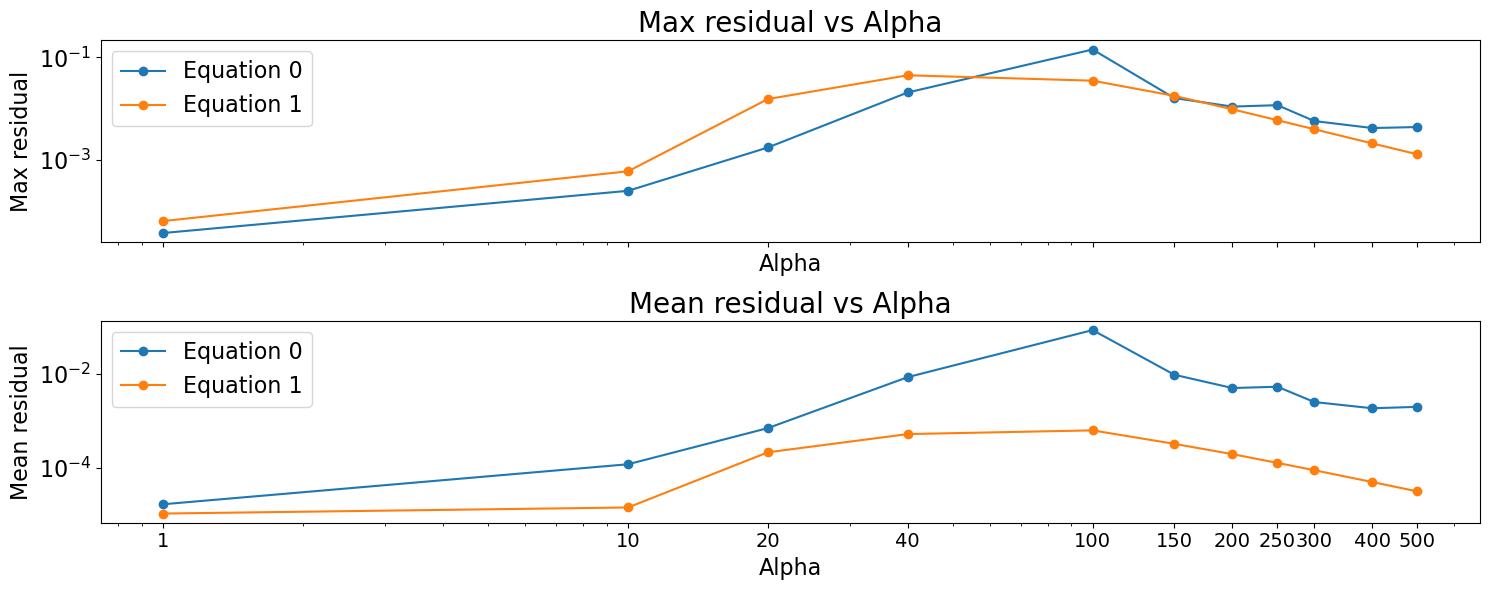

In [30]:
# do it for a list of transfer alpha
alpha_list_transfer = [1, 10, 20, 40, 100, 150, 200, 250, 300, 400, 500]
max_residual = [[] for i in range(num_equations)]
mean_residual = [[] for i in range(num_equations)]
for alpha in alpha_list_transfer:
    # DHO
    transfer_A = torch.tensor([[0., -1.], [1., 2*alpha]], device=dev)
    force_transfer = force

    # Exemple 1
    #transfer_A = torch.tensor([[2., -1.], [1-alpha, alpha]], device=dev)
    #force_transfer = lambda t: [2*np.sin(t), alpha*(np.cos(t)-np.sin(t))]

    # compute the transfer learned solution
    M_inv_new, W_out_new_A, force_terms_new = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                       v, transfer_A, force_transfer, is_A_time_dep,
                                                                       is_force_time_dep, num_equations)
    u_transfer = torch.matmul(H.double(), W_out_new_A.double())
    # plot the transfer learned solutions
    for i in range(num_equations):
      x_vals = t_eval.detach().cpu().numpy()
      predicted_vals = u_transfer[:, i, :].detach().cpu().numpy().squeeze()
      true_vals =  true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(),
                              transfer_A if is_A_time_dep else transfer_A.cpu(),
                              force_transfer if is_force_time_dep else force_transfer.detach().cpu())[i]
        
      errors = np.abs(predicted_vals - true_vals)
      max_residual[i].append(errors.max())
      mean_residual[i].append(errors.mean())

fig, ax = plt.subplots(2, tight_layout=True, figsize=(15, 6), sharex=True)

for i in range(num_equations):
  ax[0].plot(alpha_list_transfer, max_residual[i], "-o", label=f"Equation {i}")
  ax[1].plot(alpha_list_transfer, mean_residual[i], "-o", label=f"Equation {i}")

ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_title("Max residual vs Alpha", fontsize=20)
ax[0].set_xlabel('Alpha', fontsize=16)
ax[0].set_ylabel('Max residual', fontsize=16)
ax[0].set_xticks(alpha_list_transfer, [str(i) for i in alpha_list_transfer])
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=16)
ax[0].legend(loc='best', fontsize=16)
      
ax[1].set_yscale("log")
ax[1].set_title("Mean residual vs Alpha", fontsize=20)
ax[1].set_xlabel('Alpha', fontsize=16)
ax[1].set_ylabel('Mean residual', fontsize=16)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=16)
ax[1].legend(loc='best', fontsize=16)    
